<h1 style="text-align:center"> Building Data Pipeline </h1>
<img src=Spotify_arch.png>

---
<h5> Useful Link: </h5>
<a href="https://developer.spotify.com/console/get-recently-played/">Spotify Developer Console Link</a>

---

In [1]:
import pymongo
from pymongo import MongoClient
import logging as logger
import pandas as pd
import requests
import json
import datetime
from config import USER_ID, TOKEN

In [2]:
# making connection to the mongodb local host
client = MongoClient('mongodb://localhost:27017')

In [3]:
# get the name of the databases
client.list_database_names()

['admin', 'config', 'local', 'mydb']

In [4]:
# setting the database to mydb
db = client.mydb

In [5]:
# list the collections present in the database
db.list_collection_names()

['test_collection']

In [6]:
# create collection called spotify_songs (if present it uses it)
collection = db.spotify_songs

In [7]:
logger.basicConfig(filename = 'AuditLogger.log',
                   filemode = 'w',
                   level = logger.INFO,
                   format = '%(asctime)s - %(levelname)s - %(message)s')

In [8]:
#USER_ID = '31x324qx7jljp3mc6bok27jm6kca'
#TOKEN = 'BQAG8S6Jjz1kJkL-wdNjenHvu87fgECOb2EL6L5gJtyTkOfuy5JZuQYqz0e3tjzmQidL6ePaLHI55sICXoKQ9YDWohf5YAvY0nKXPEDZyC1n_82X2cB4lfbcwNL1m_scnNAAzDwHB9M9CWGbzvtCvilhOm6ew_yS_ma2ekEb'

In [9]:
if __name__ == "__main__":
    headers ={
        "Accept":"application/json",
        "Content-Type":"application/json",
        "Authorization":"Bearer {token}".format(token=TOKEN)
    }

In [10]:
today = datetime.datetime.now()
yesterday = today - datetime.timedelta(days=2)
yesterday_unix_timestamp = int(yesterday.timestamp()) * 1000

In [11]:
try:
    logger.info("*" * 30)
    logger.info("Making HTTP request to the API")
    r = requests.get("https://api.spotify.com/v1/me/player/recently-played?after={time}".format(time=yesterday_unix_timestamp), headers = headers)
    if ('401' in str(r)) == True:
        raise Exception('HTTP 401 ERROR')
except Exception as e:
    logger.error("{}".format(e))

In [238]:
data = r.json()

In [206]:
if 'error' in list(data.keys()):
    print('Error loading the data from spotify API')

Error loading the data from spotify API


In [64]:
song_names = []
artist_names = []
played_at_list = []
#timestamps = []

In [65]:
for song in data['items']:
    song_names.append(song['track']['name'])
    artist_names.append(song['track']['album']['artists'][0]['name'])
    played_at_list.append(song['played_at'])
    #timestamps.append(song["played_at"][0:10])

In [66]:
song_dict = {
    "song_name" : song_names,
    "artist_name" : artist_names,
    "played_at" : played_at_list
    #"timestamp" : timestamps
}

In [91]:
# songs_df = pd.DataFrame(song_dict, columns=["song_name", "artist_name", "played_at"])
song_df = pd.DataFrame(song_dict)

In [92]:
song_df

,song_name,artist_name,played_at
0,Fire Away,Nora Van Elken,2022-02-25T02:03:21.476Z
1,Firestone,Kygo,2022-02-25T02:00:33.723Z
2,Never Going Home,Kungs,2022-02-25T01:56:03.209Z
3,Beautiful,Deepend,2022-02-25T01:53:12.177Z
4,Want It,Mihail Cirstea,2022-02-25T01:50:17.342Z
5,Be Kind (with Halsey),Marshmello,2022-02-25T01:46:36.096Z
6,Hands Up,B. Ajaneesh Loknath,2022-02-24T03:08:29.404Z
7,abcdefu,GAYLE,2022-02-24T03:07:54.506Z
8,abcdefu,GAYLE,2022-02-24T03:04:18.206Z
9,abcdefu,GAYLE,2022-02-24T02:58:00.357Z


In [93]:
# for recs in range(len(song_dict["song_name"])):
#     for row in song_dict:
#         print(song_dict[row][recs])

In [95]:
# checking the datatypes of the fields
print(song_df.dtypes)

song_name      object
artist_name    object
played_at      object
dtype: object


In [96]:
song_df["played_at"] = pd.to_datetime(song_df["played_at"]).dt.strftime('%Y-%m-%d')
song_df['song_name'] = song_df['song_name'].astype('str')
song_df['artist_name'] = song_df['artist_name'].astype('str')

In [182]:
db.spotify_songs.insert_many(song_df.to_dict('records'))

In [136]:
song_df['identity'] = 1
song_df

,song_name,artist_name,played_at,identity
0,Fire Away,Nora Van Elken,2022-02-25,1
1,Firestone,Kygo,2022-02-25,1
2,Never Going Home,Kungs,2022-02-25,1
3,Beautiful,Deepend,2022-02-25,1
4,Want It,Mihail Cirstea,2022-02-25,1
5,Be Kind (with Halsey),Marshmello,2022-02-25,1
6,Hands Up,B. Ajaneesh Loknath,2022-02-24,1
7,abcdefu,GAYLE,2022-02-24,1
8,abcdefu,GAYLE,2022-02-24,1
9,abcdefu,GAYLE,2022-02-24,1


In [133]:
song_df.groupby('song_name').count()

,artist_name,played_at
song_name,,
Be Kind (with Halsey),1,1
Beautiful,1,1
Bijlee Bijlee,1,1
Chandrachooda,1,1
Dil Laga Liya Maine,1,1
Fire Away,1,1
Firestone,1,1
Gangsta's Paradise,1,1
Gudilo Badilo Madilo,1,1


In [151]:
song_df = song_df.drop(['identity'], axis=1)
song_df

,song_name,artist_name,played_at
0,Fire Away,Nora Van Elken,2022-02-25
1,Firestone,Kygo,2022-02-25
2,Never Going Home,Kungs,2022-02-25
3,Beautiful,Deepend,2022-02-25
4,Want It,Mihail Cirstea,2022-02-25
5,Be Kind (with Halsey),Marshmello,2022-02-25
6,Hands Up,B. Ajaneesh Loknath,2022-02-24
7,abcdefu,GAYLE,2022-02-24
8,abcdefu,GAYLE,2022-02-24
9,abcdefu,GAYLE,2022-02-24


In [176]:
v_df = song_df.groupby(['song_name']).size()

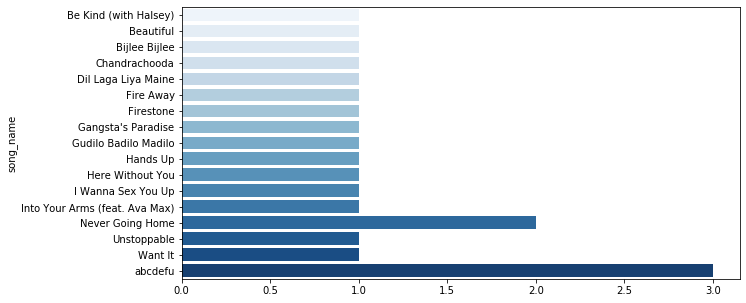

In [181]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(y = v_df.index, x = v_df.values, palette = "Blues")